Analysis on crowdflower dataset

## Import

In [0]:
import pandas as pd
import numpy as np

In [0]:
import pickle
import sys
import nltk
from nltk.stem.porter import *

from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cf_data = pd.read_csv('/content/drive/My Drive/Hate_Speech_Detection_git/data_2/labeled_data.csv')

In [0]:
cf_data.rename_axis({'Unnamed: 0':'id_col'},axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  """Entry point for launching an IPython kernel.


## Basic Data Analysis

In [0]:
cf_data.head()

,id_col,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).

hate_speech = number of CF users who judged the tweet to be hate speech.

offensive_language = number of CF users who judged the tweet to be offensive.

neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.

class = class label for majority of CF users.

0 - hate speech

1 - offensive  language

2 - neither

So basically now our target is variable class, which we will convert to a binary target further 

### Target Analysis

In [0]:
cf_data['class'].value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

so basically the hate speech count is 1430+19190, and not hate speech count is 4163

In [0]:
train = cf_data.copy()

### Very basic exploration

In [0]:
## word and char count, avg_word length and all
train['word_count'] = train['tweet'].apply(lambda x: len(str(x).split(" ")))
train[['tweet','word_count']].head()

,tweet,word_count
0,!!! RT @mayasolovely: As a woman you shouldn't...,25
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,16
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,21
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,9
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,26


In [0]:
train['char_count'] = train['tweet'].str.len() ## this also includes spaces
train[['tweet','char_count']].head()

,tweet,char_count
0,!!! RT @mayasolovely: As a woman you shouldn't...,140
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,85
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,120
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,62
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,137


In [0]:
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

train['avg_word'] = train['tweet'].apply(lambda x: avg_word(x))
train[['tweet','avg_word']].head()

,tweet,avg_word
0,!!! RT @mayasolovely: As a woman you shouldn't...,4.640000
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,4.375000
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,4.761905
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,6.000000
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,4.307692


#### Hashtags

In [0]:
train['hastags'] = train['tweet'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
train[['tweet','hastags']].head()

,tweet,hastags
0,!!! RT @mayasolovely: As a woman you shouldn't...,0
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,0
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,0
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,0
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,0


### Basic Preprocessing

In [0]:
train['tweet']

0        !!! RT @mayasolovely: As a woman you shouldn't...
1        !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2        !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3        !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4        !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5        !!!!!!!!!!!!!!!!!!"@T_Madison_x: The shit just...
6        !!!!!!"@__BrighterDays: I can not just sit up ...
7        !!!!&#8220;@selfiequeenbri: cause I'm tired of...
8        " &amp; you might not get ya bitch back &amp; ...
9        " @rhythmixx_ :hobbies include: fighting Maria...
10       " Keeks is a bitch she curves everyone " lol I...
11                      " Murda Gang bitch its Gang Land "
12       " So hoes that smoke are losers ? " yea ... go...
13           " bad bitches is the only thing that i like "
14                                 " bitch get up off me "
15                         " bitch nigga miss me with it "
16                                  " bitch plz whatever

Every word followed by @ is some twitter ID of an user, which shouldn't be considered in our analysis, so lets do the stemming, where we remove @ alonwith the word followed by it

#### Removing user IDs from text

In [0]:
check = train['tweet'][0]
c = ' '.join(i for i in [a for a in check.split() if not a.startswith('@')])

In [0]:
train['tweet'] = train['tweet'].apply(lambda x:' '.join(i for i in [a for a in x.split() if a.find('@')==-1]))

#### Converting to Lower case

In [0]:
train['tweet'] = train['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
train['tweet'].head()

0    !!! rt as a woman you shouldn't complain about...
1    !!!!! rt boy dats cold...tyga dwn bad for cuff...
2    !!!!!!! rt dawg!!!! rt you ever fuck a bitch a...
3                  !!!!!!!!! rt she look like a tranny
4    !!!!!!!!!!!!! rt the shit you hear about me mi...
Name: tweet, dtype: object

There is no use of punctuation mostly, so removing it

In [0]:
train['tweet'] = train['tweet'].str.replace('[^\w\s]','')
train['tweet'].head()

0     rt as a woman you shouldnt complain about cle...
1     rt boy dats coldtyga dwn bad for cuffin dat h...
2     rt dawg rt you ever fuck a bitch and she star...
3                            rt she look like a tranny
4     rt the shit you hear about me might be true o...
Name: tweet, dtype: object

#### Removing stopwords

In [0]:
import nltk
# nltk.download('stopwords')

In [0]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
train['tweet'] = train['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
train['tweet'].head()

0    rt woman shouldnt complain cleaning house amp ...
1    rt boy dats coldtyga dwn bad cuffin dat hoe 1s...
2    rt dawg rt ever fuck bitch start cry confused ...
3                                  rt look like tranny
4    rt shit hear might true might faker bitch told...
Name: tweet, dtype: object

#### Most common and rare words

In [0]:
freq = pd.Series(' '.join(train['tweet']).split()).value_counts()[:10]
freq

bitch      8120
rt         7578
bitches    3045
like       2759
hoes       2328
pussy      2073
im         2063
hoe        1866
dont       1749
ass        1562
dtype: int64

rt is a very frequent word occuring almost in every tweet, and it doesnt hold any meaning so lets just remove it, I guess it there are such more words but those are all seem to be hatespeech. So we will just keep hate speechwords from above list, lets remove the rest

In [0]:
remove_word = ['rt','like','im','dont']

In [0]:
train['tweet'] = train['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in remove_word))
train['tweet'].head()

0    woman shouldnt complain cleaning house amp man...
1    boy dats coldtyga dwn bad cuffin dat hoe 1st p...
2         dawg ever fuck bitch start cry confused shit
3                                          look tranny
4    shit hear might true might faker bitch told ya...
Name: tweet, dtype: object

In [0]:
freq = pd.Series(' '.join(train['tweet']).split()).value_counts()#[-20000:]
freq

bitch                        8120
bitches                      3045
hoes                         2328
pussy                        2073
hoe                          1866
ass                          1562
get                          1428
fuck                         1406
got                          1289
u                            1272
shit                         1249
nigga                        1191
aint                         1157
trash                        1124
lol                          1033
amp                           839
know                          805
niggas                        787
one                           697
love                          695
cant                          661
yall                          646
fucking                       626
go                            620
thats                         610
yo                            609
want                          581
bad                           567
youre                         559
good          

In [0]:
freq.shape

(28240,)

Doesnt really make sense to remove rare words, i.e. the words with count 1. Because we might lose hateful words this way

In [0]:
from textblob import TextBlob
# nltk.download('punkt')
TextBlob(train['tweet'][1]).words

WordList(['boy', 'dats', 'coldtyga', 'dwn', 'bad', 'cuffin', 'dat', 'hoe', '1st', 'place'])

#### Lemmetization
smart stemming

In [0]:
from textblob import Word
# nltk.download('wordnet')
train['tweet'] = train['tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
train['tweet'].head()

0    woman shouldnt complain cleaning house amp man...
1    boy dat coldtyga dwn bad cuffin dat hoe 1st place
2         dawg ever fuck bitch start cry confused shit
3                                          look tranny
4    shit hear might true might faker bitch told ya...
Name: tweet, dtype: object

#### Viz of length of tweets vs class

In [0]:
### no of words in a tweets
# train['length_of_tweets'] = train['tweet'].apply(lambda x:len(x.split()))

### but considering no of characters used seem more significant
train['length_of_tweets'] = train['tweet'].apply(lambda x:len(x))

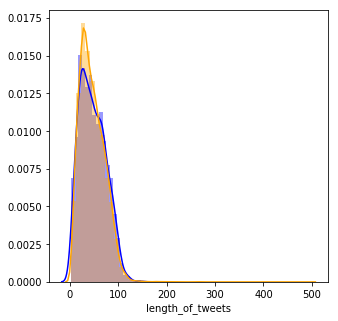

In [0]:
plt.figure(figsize=(5,5))
sns.distplot(train[train['class']==0]['length_of_tweets'],color='blue')
sns.distplot(train[train['class']==1]['length_of_tweets'],color='orange')
plt.show()

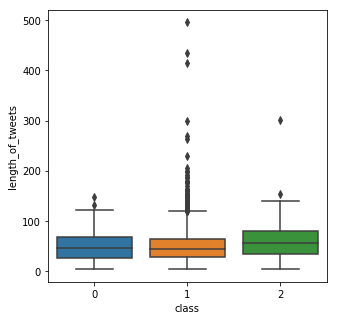

In [0]:
plt.figure(figsize=(5,5))
sns.boxplot(y = train['length_of_tweets'],x=train['class'])
plt.show()

In [0]:
train[train['class']==0]['length_of_tweets'].describe()

count    1430.000000
mean       47.652448
std        26.165917
min         3.000000
25%        26.000000
50%        45.000000
75%        67.000000
max       147.000000
Name: length_of_tweets, dtype: float64

In [0]:
train[train['class']==1]['length_of_tweets'].describe()

count    19190.000000
mean        46.611777
std         25.448135
min          3.000000
25%         27.000000
50%         43.000000
75%         64.000000
max        496.000000
Name: length_of_tweets, dtype: float64

##### So now it seems that the data is almost clean! Lets explore advanced preprocessing/ text representation techniques

### Target creation

In [0]:
train['class'].replace([0,1,2],[1,1,0],inplace=True)
train['class'].value_counts()

1    20620
0     4163
Name: class, dtype: int64

### N-Grams

In [0]:
TextBlob(train['tweet'][0]).ngrams(2)

[WordList(['woman', 'shouldnt']),
 WordList(['shouldnt', 'complain']),
 WordList(['complain', 'cleaning']),
 WordList(['cleaning', 'house']),
 WordList(['house', 'amp']),
 WordList(['amp', 'man']),
 WordList(['man', 'always']),
 WordList(['always', 'take']),
 WordList(['take', 'trash'])]

### TF-IDF

In [0]:
from sklearn.model_selection import train_test_split
x_t,x_v,y_t,y_v = train_test_split(train['tweet'],train['class'],test_size=0.2,random_state=234)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
 stop_words= 'english',ngram_range=(1,1))

tfidf.fit(train['tweet'])

x_t = tfidf.transform(x_t)
x_v = tfidf.transform(x_v)


In [0]:
x_t.todense().shape

(19826, 1000)

In [0]:
x_t.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
clf = LogisticRegression()
clf.fit(x_t,y_t)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
clf.score(x_v,y_v)

0.9435142223118822

In [0]:
from sklearn.metrics import f1_score, classification_report, roc_auc_score
f1_score(clf.predict(x_v),y_v)

0.9663704059572424

In [0]:
print(classification_report(clf.predict(x_v),y_v))

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       760
           1       0.97      0.96      0.97      4197

    accuracy                           0.94      4957
   macro avg       0.88      0.91      0.90      4957
weighted avg       0.95      0.94      0.94      4957



### Manually inspecting the predictions

In [0]:
truth_check = (clf.predict(x_v)==y_v)

In [0]:
good_preds = train.iloc[truth_check[truth_check==True].index]

##### Non hate speech good preds

In [0]:
good_preds[good_preds['class']==0]['tweet']

20085    pink fuzzy one amp silky silver one bathrobe w...
8283                      california gang california trash
4992                        yankee florida state floridian
9671     happy hangover bloomington btown iubb iu india...
4299                                        brownie 128546
8418     charlie crist losing 50000 florida job raise m...
8339          cant find bc powder ill chug childrens advil
10402    grew hate blonde primary colored weave wouldnt...
22796        whipped french front babe post office winning
20935    ive pretty paranoid cooling weather bringing a...
21664    zerah cushite came army one million men 300 ch...
12956    baby boy asleep monkey since little love son m...
10020    extremely sad admit best 21st century arabic r...
22810        need alarm world annoying bird outside window
575      two road diverged yellow wood chose one j246tu...
2192     al qaeda market share dropping faster viacom a...
18159    shine light yankee pinstripe honor derek jeter.

##### Hate speech good preds

In [0]:
good_preds[good_preds['class']==1]['tweet']

23848                     get level bitch careful kick wit
23797    even tho killed pussy nigga hope go heaven you...
23384                      never invite anywhere yet bitch
4329     yep messiermore dangerousmore environmentallyu...
5868                                               snag ho
1328     null bruh alive thats han bitch died8221 oh we...
13330    nigga fall love evil bitch turn back friend co...
3962     hey aklve taking black ghetto trash youre bloc...
18298    choose fuck bitch theyre easy hard presidentia...
6733                  lmao would respect he hoe thats true
8799               get yo bitch as killed new atlanta baby
4398                      biebs getting fucked right pussy
17849                           cant fw friendly bitch8221
4024                                             bitch get
8936                                  ebola sound hood hoe
20159    dat shit trash shirt inspired emoji tattoo pre...
14715    perfect visionme niggs ma hoe ma clicquot ma d.

#### Bad preds

In [0]:
bad_preds = train.iloc[truth_check[truth_check==False].index]

##### Bad pred non hate speeches

In [0]:
bad_preds[bad_preds['class']==0]['tweet']

17179    real reason gave rapping called trash face n a...
741                                         np century fob
8689                                          define wigga
509                            albino mexican dad he asian
2377                         may cried tad illmissu shiner
5926                                              wasp egg
5082     marxist kike promoted antisemitism creating fi...
17447                                  sav nicee love twat
10813    openly admit level white trash drive across to...
3037                           hoe hoe hoe merry christmas
11232    18 year old gay driving back road redneck virg...
21893       use call mom jap younger lol asian racial slur
21518    beautiful fairy pool near glenbrittle isle sky...
2358              thats ghetto thats sweet movie quote try
950                          128075 hiho httptcofic4fnrutz
9481                gone bust open real nicca 128540128540
9450                         glad aint got bird leg 1285

#### Bad preds hate speeches

In [0]:
bad_preds[bad_preds['class']==1]['tweet']

24778    yous muthafin lie right tl trash 8230 mine bib...
20453    commence carpet bombing iraq soldier video htt...
14344    shawn micheals amp razor ramon bitches8221 noo...
18991    friend 2014 malibu legroom ventilation necessa...
3054     enraged 64 290 lb mike brown lethal weapon leg...
13801    people grow vegetable nothing common peasant t...
2758     know know name somebody colder monkey faced im...
20180    apr 29th 1997 released album killfuckdie taket...
13519    obama8217s faves muslim black ghetto trash htt...
3529                                     sure aint colored
5924                                        rhyming ghetto
4350     liar ever republican teabagger asshats stockbo...
5538     absolutely agree statement amusing angry make ...
17804    baffle people talk upmost trash someone turn a...
4480        popped molly every day last year beatthatbitch
5619                          yeah cum itch slit baby cake
3033     soul departed traintheres soul musicjust hunge.

### Word2Vec Approach

In [0]:
import gensim
import logging

In [0]:
from gensim.models import Word2Vec

In [0]:
wv = gensim.models.KeyedVectors.load_word2vec_format("/content/drive/My Drive/Hate_Speech_Detection_git/GoogleNews-vectors-negative300.bin.gz", binary=True)


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
wv.init_sims(replace=True)

In [0]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [0]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
train_w2v, test_w2v = train_test_split(train, test_size=0.2, random_state = 42)
# x_t,x_v,y_t,y_v = train_test_split(train['tweet'],train['class'],test_size=0.2,random_state=234)

test_tokenized = test_w2v.apply(lambda r: w2v_tokenize_text(r['tweet']), axis=1).values
train_tokenized = train_w2v.apply(lambda r: w2v_tokenize_text(r['tweet']), axis=1).values

X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
from sklearn.metrics import accuracy_score

In [0]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train_w2v['class'])
y_pred = logreg.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred, test_w2v['class']))
print(classification_report(test['class'], y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy 0.9233407302804115
              precision    recall  f1-score   support

           0       0.79      0.74      0.76       835
           1       0.95      0.96      0.95      4122

    accuracy                           0.92      4957
   macro avg       0.87      0.85      0.86      4957
weighted avg       0.92      0.92      0.92      4957



### Dont know something weird

In [0]:
from nltk.tokenize import word_tokenize

from sklearn.preprocessing import scale

from sklearn.base import TransformerMixin

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.svm import SVC
from sklearn.svm import LinearSVC

In [0]:
X = train['tweet']
y = train['class']

In [0]:
class MeanEmbeddingTransformer(TransformerMixin):
    
    def __init__(self):
        self._vocab, self._E = self._load_words()
        
    
    def _load_words(self):
        E = {}
        vocab = []

        with open('./glove_twitter_27B/glove.twitter.27B.50d.txt', 'r', encoding="utf8") as file:
            for i, line in enumerate(file):
                l = line.split(' ')
                if l[0].isalpha():
                    v = [float(i) for i in l[1:]]
                    E[l[0]] = np.array(v)
                    vocab.append(l[0])
        return np.array(vocab), E            

    
    def _get_word(self, v):
        for i, emb in enumerate(self._E):
            if np.array_equal(emb, v):
                return self._vocab[i]
        return None
    
    def _doc_mean(self, doc):
        return np.mean(np.array([self._E[w.lower().strip()] for w in doc if w.lower().strip() in self._E]), axis=0)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.array([self._doc_mean(doc) for doc in X])
    
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

In [0]:
def tokenize_and_transform(X, sample_size):
    tweets = X
    tok_es1 = [word_tokenize(doc) for doc in tweets[:sample_size]]
    met = MeanEmbeddingTransformer()
    X_transform = tok_es1
    return X_transform

In [0]:
X_transform = tokenize_and_transform(X, 24783)

In [0]:
len(X_transform)

24783